In [23]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import datetime
import seaborn as sn
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
%matplotlib inline

In [212]:
train = pd.read_csv("train_mod5.csv")
print(list(train.columns.values))

['parcelid', 'logerror', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'airconditioningtypeid_Central', 'airconditioningtypeid_EvaporativeCooler', 'airconditioningtypeid_None', 'airconditioningtypeid_Refrigeration', 'airconditioningtypeid_WallUnit', '

In [213]:
train_x = train.drop(['logerror'],axis=1,inplace=False)
train_y = train['logerror']

In [214]:
# Split train_x, train_y into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.15, random_state=42)
print("Training set size: {}".format(len(X_train)))
print("Validation set size: {}".format(len(X_val)))

Training set size: 114432
Validation set size: 20195


In [215]:
dm_train = xgb.DMatrix(X_train, label=y_train)
dm_valid = xgb.DMatrix(X_val, label=y_val)

In [160]:
def score(params):
    num_round = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])

    watchlist = [(dm_train, 'train'), (dm_valid, 'eval')]
    model = xgb.train(params, dm_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=200)
    predictions = model.predict(dm_valid)
    score = mean_absolute_error(y_val, predictions)    
    print("############### Score: {0}".format(score))
    print("############### Params: ", params)
    return {'loss': score, 'status': STATUS_OK}

In [161]:
def optimize(trials):
    space = {
             'eta' : hp.quniform('eta', 0.01, 0.1, 0.01),
             'max_depth' : hp.quniform('max_depth', 3, 6, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.8, 1.5, 0.05),
             'gamma' : hp.quniform('gamma', 0.6, 1.0, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 1, 0.05),
             'eval_metric': 'mae',
             'objective': 'reg:linear',
             'silent' : 1
             }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)
    print (best)

In [68]:
trials = Trials()
optimize(trials)

In [216]:
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['min_child_weight'] = 3
params['subsample'] = 1.0
params['gamma'] = 0.7
params['colsample_bytree'] = 0.9
params['silent'] = 1

watchlist = [(dm_train, 'train'), (dm_valid, 'valid')]
bst = xgb.train(params, dm_train, 600, watchlist, early_stopping_rounds=50, verbose_eval=100)
#dm_trainvalid = xgb.DMatrix(train_x, label=train_y)
#bst = xgb.cv(params, dm_trainvalid, num_boost_round=600, nfold=5, early_stopping_rounds=50, verbose_eval=100)


[0]	train-mae:0.486596	valid-mae:0.486317
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[100]	train-mae:0.102114	valid-mae:0.101713
[200]	train-mae:0.070658	valid-mae:0.070252
[300]	train-mae:0.068931	valid-mae:0.068653
[400]	train-mae:0.068717	valid-mae:0.068555
Stopping. Best iteration:
[403]	train-mae:0.068713	valid-mae:0.068553



In [217]:

bst.save_model("xgb_mod5.model")


In [218]:
test = pd.read_csv('test_mod5.csv')
test_x = test.drop(['logerror'],axis=1,inplace=False)

In [219]:
# Get missing columns in the training test
missing_cols = set( train_x.columns ) - set( test_x.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_x[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_x = test_x[train_x.columns]

In [220]:
dm_test = xgb.DMatrix(test_x)
test_y = bst.predict(dm_test)


test_y = pd.DataFrame(test_y)
test_y.columns = ["prediction"]

In [221]:
submission = pd.DataFrame()
submission["parcelid"] = test['parcelid'].copy()
submission["logerror"] = test['logerror'].copy()
submission["prediction"] = test_y["prediction"].copy()
ground_truth = submission["logerror"].values
predictions = submission["prediction"].values
abs_error = abs(ground_truth - predictions)
submission["abs_error"] = abs_error

# Calculate mean absolute error
mae = mean_absolute_error(ground_truth, predictions)
print("Mean Absolute Error: {}".format(mae))

Mean Absolute Error: 0.06925752883304284


In [225]:
filename = 'xgb_preds_mod6.csv'
print(filename)
submission.to_csv(filename,index=False)

xgb_preds_mod6.csv


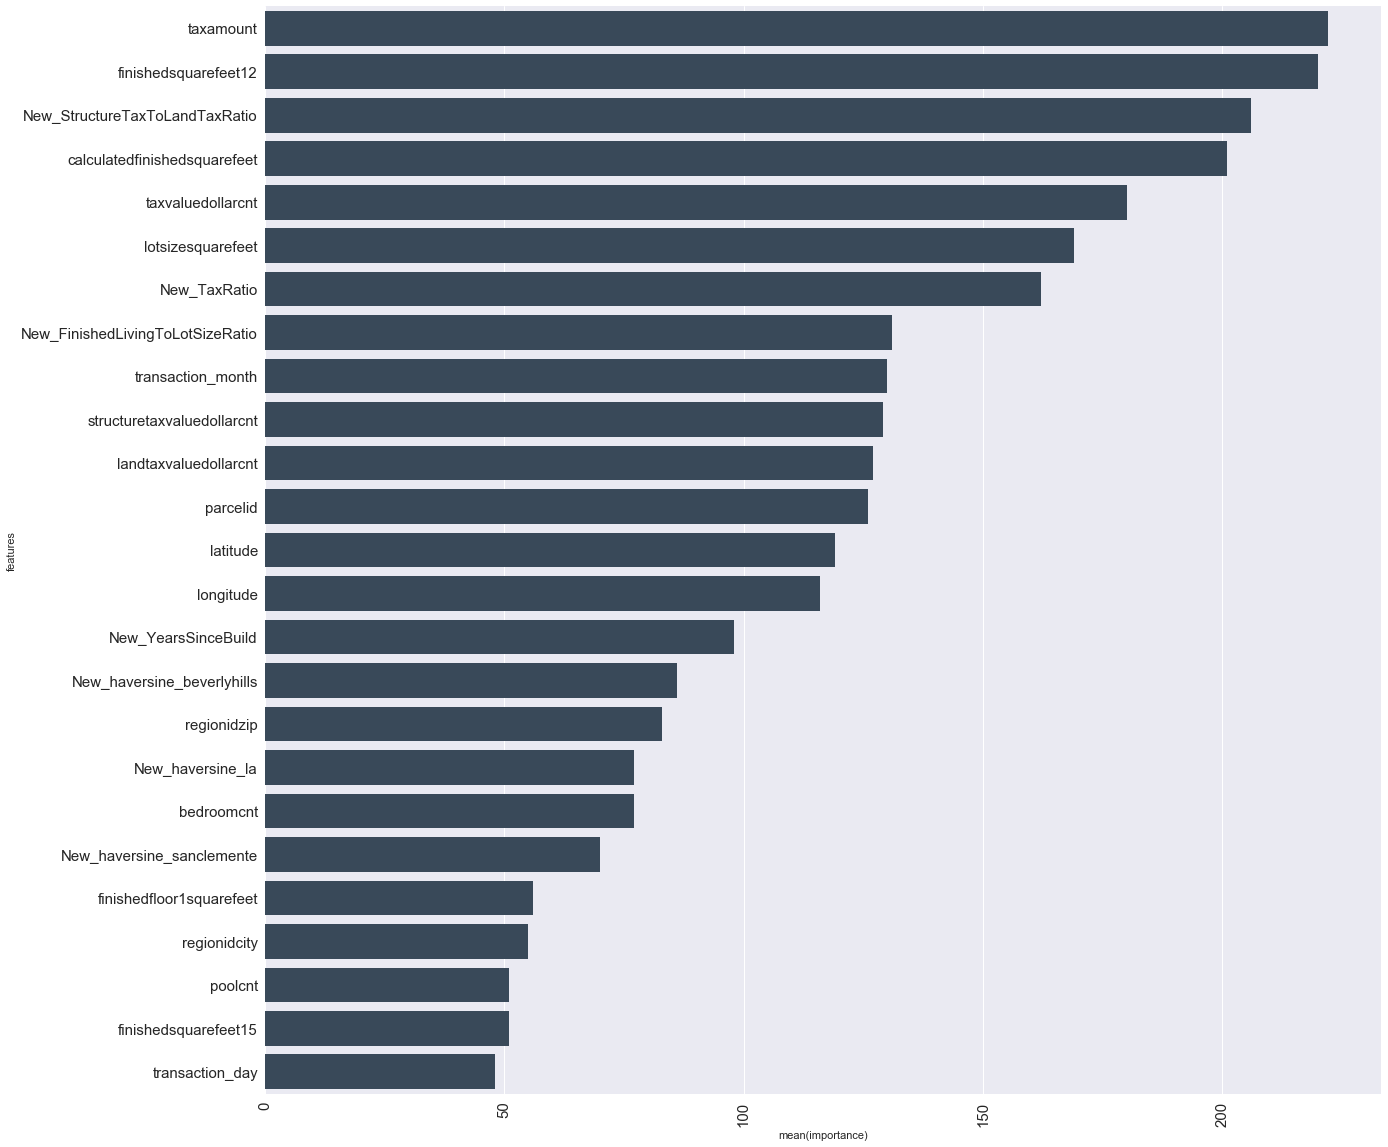

In [223]:
featureImportance = bst.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
sn.barplot(data=features.head(25),x="importance",y="features",ax=ax,orient="h",color="#34495e")

# Ensemble

In [226]:
#mod1 = pd.read_csv("xgb_preds_mod1.csv")
#mod2 = pd.read_csv("xgb_preds_mod2.csv")
mod6 = pd.read_csv("xgb_preds_mod6.csv")
mod4 = pd.read_csv("xgb_preds_mod4.csv")
#randforest = pd.read_csv("RandForestPrediction.csv")
test = pd.read_csv('test.csv')
ground_truth = test['logerror'].values


/Users/BurrusRA/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [227]:
ensemble = pd.DataFrame()
#ensemble['errors_randforest'] = randforest["abs_error"].values
#ensemble['errors_mod1'] = mod1["abs_error"].values
ensemble['errors_mod4'] = mod4["abs_error"].values
ensemble['errors_mod6'] = mod6["abs_error"].values

In [228]:
ensemble['mean'] = (ensemble['errors_mod4'].values +
                    ensemble['errors_mod6'].values) / 2

In [229]:
count = len(ensemble['mean'])
total_abs_error = sum(ensemble['mean'])
mae = total_abs_error / count
print("Mean Absolute Error: {}".format(mae))

Mean Absolute Error: 0.0692115163992686
